<a href="https://colab.research.google.com/github/prbsh9/Neural_Style_Transfer/blob/master/Art%2BGeneration%2Bwith%2BNeural%2BStyle%2BTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Art: Neural Style Transfer


**LETS:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 



In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import zipfile

%matplotlib inline

In [0]:
from nst_utils import *


Saving content.jpg to content.jpg
Saving style.jpg to style.jpg


In [0]:
model = load_vgg_model("/tmp/imagenet-vgg-verydeep-19.mat")
print(model)

Instructions for updating:
Colocations handled automatically by placer.
{'input': <tf.Variable 'Variable:0' shape=(1, 425, 425, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 425, 425, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 425, 425, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 213, 213, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 213, 213, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 213, 213, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 107, 107, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 107, 107, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 107, 107, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 107, 107, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 107, 107, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 54, 54, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


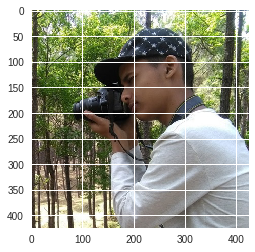

In [0]:
content_image = scipy.misc.imread("content.jpg")
imshow(content_image)

In [0]:
print(tf.__version__)

1.13.1


In [0]:

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C =  a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[ n_H*n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[ n_H*n_W, n_C]))
    
    # compute the cost with tensorflow 
    J_content = 1/(4 * n_H * n_C * n_W) *tf.reduce_sum(tf.square(tf.subtract(a_C , a_G)))
    
    return J_content

In [0]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655935


**Expected Output**:

<table>
    <tr>
        <td>
            **J_content**
        </td>
        <td>
           6.76559
        </td>
    </tr>

</table>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


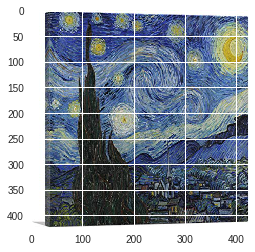

In [0]:
style_image = scipy.misc.imread("style.jpg")
imshow(style_image)

In [0]:

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [0]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305  -4.4291224 -2.096682 ]
 [-4.4291224 19.465837  19.563871 ]
 [-2.096682  19.563871  20.686462 ]]


In [0]:

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    
    return J_style_layer

In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [0]:
a = np.array([[1,2,3],[4,5,6]])
a = a.reshape(3,2)

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [0]:

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

In [0]:
# tf.reset_default_graph()

# with tf.Session() as test:
#     np.random.seed(3)
#     J_content = np.random.randn()    
#     J_style = np.random.randn()
#     J = total_cost(J_content, J_style)
#     print("J = " + str(J))

In [0]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [0]:
content_image = scipy.misc.imread("content.jpg")
content_image = reshape_and_normalize_image(content_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [0]:
style_image = scipy.misc.imread("style.jpg")
style_image = reshape_and_normalize_image(style_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


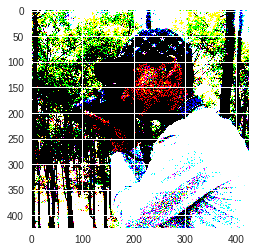

In [0]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [0]:
model = load_vgg_model("/tmp/imagenet-vgg-verydeep-19.mat")

In [0]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [0]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [0]:
J = total_cost(J_content,  J_style)



In [0]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step 
train_step = optimizer.minimize(J)

In [0]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    
    generated_image = sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])


    # save last generated image
    save_image('/tmp/generated_image.jpg', generated_image)
    
    return generated_image

In [0]:
model_nn(sess, generated_image)

array([[[[ 174.89159  ,  143.15915  ,  153.16353  ],
         [ 114.52579  ,   81.128555 ,  138.60565  ],
         [ -37.667843 ,   33.59749  ,   90.42273  ],
         ...,
         [ -73.70155  ,  -18.945019 ,   56.81121  ],
         [ -93.29318  ,  -26.827545 ,   97.68157  ],
         [  85.36774  ,   99.82836  ,  126.96014  ]],

        [[ 121.60687  ,  113.35272  ,  147.20982  ],
         [  85.412186 ,   77.303215 ,  113.230125 ],
         [  11.228121 ,   29.959467 ,   94.83372  ],
         ...,
         [ -69.588905 ,  -24.175848 ,   41.803513 ],
         [ -71.472404 ,  -15.927391 ,   98.13742  ],
         [ 111.79673  ,  117.568275 ,  141.88908  ]],

        [[ 124.88784  ,   84.93993  ,  125.814995 ],
         [ 105.84774  ,   95.69616  ,  106.07813  ],
         [   2.2979417,   34.607597 ,   94.259735 ],
         ...,
         [ -78.690254 ,  -20.802221 ,   31.585306 ],
         [  39.11759  ,   31.22118  ,  115.88587  ],
         [ 122.06908  ,  146.0751   ,  150.97543  ]],

In [0]:
from google.colab import files

files.download('/tmp/generated_image.jpg')

**Surprise!! Try it yourself to see what is the result! LOL.. **
<br> 

** Thank you for seeing it dude!!**